In [39]:
import time
from tqdm import tqdm
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import cProfile
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs)*sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
        
    def forward(self, X):
        X = X.reshape(-1, self.num_inputs)
        H = relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2

(90.34923669695854, 16.41049399971962)

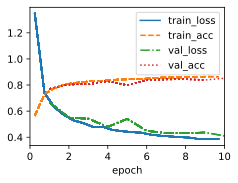

In [1]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

(88.42640492320061, 17.865788638591766)

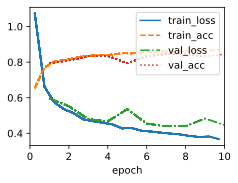

In [3]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
        
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 1. Change the number of hidden units num_hiddens and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?

As the number of hidden units grows, accuracy of the model increases first and goes down after 4096, so **4096** might be the best value of this hyperparameter

In [38]:
def stat_acc(num_hiddens):
    model = MLP(num_outputs=10, num_hiddens=num_hiddens, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

hiddens = d2l.gen_logrithm_nums(initial_value = 64, growth_factor = 2, num_elements = 8)
accs = []
for num_hiddens in tqdm(hiddens):
    accs.append(stat_acc(num_hiddens))

100%|██████████| 8/8 [23:02<00:00, 172.78s/it]


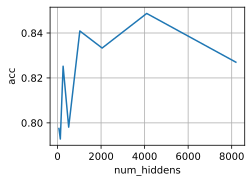

In [42]:
d2l.plot(hiddens,accs,'num_hiddens','acc')

# 2. Try adding a hidden layer to see how it affects the results.

As we add a hidden layer, the accuracy improves.

In [46]:
class MulMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for num in num_hiddens:
            layers.append(nn.LazyLinear(num))
            layers.append(nn.ReLU())
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)

acc: 0.79


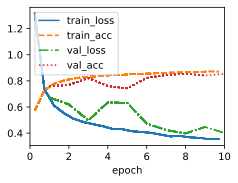

In [35]:
model = MulMLP(num_outputs=10, num_hiddens=[256,128], lr=0.1)
trainer = d2l.Trainer(max_epochs=10, plot_flag=True)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

# 3. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?



Inserting a hidden layer with a single neuron in a neural network can lead to several issues and limitations. This configuration is often referred to as a "bottleneck layer" or "degenerate layer." While it's not inherently incorrect, it can have negative consequences for the network's performance, training dynamics, and capacity to learn complex patterns. Here are some of the problems that can arise:

1. **Loss of Expressiveness:** A single neuron in a hidden layer severely limits the expressive power of the network. Neural networks derive their power from their ability to model complex nonlinear relationships through multiple layers and neurons. A single neuron cannot capture complex relationships, leading to a lack of representational capacity.

2. **Limited Feature Learning:** Neural networks typically learn useful features in hidden layers through a hierarchy of representations. A single hidden neuron lacks the capacity to learn diverse and meaningful features, which can hinder the network's ability to generalize from the data.

3. **High Bias:** A single neuron can easily become biased towards capturing a specific pattern or representation, leading to poor generalization to new data. The network may overfit to the training data and fail to capture the underlying patterns.

4. **Vanishing Gradients:** With just one neuron in the hidden layer, the gradients that flow backward during training can become extremely small or even vanish. This makes weight updates difficult, leading to slow convergence or no convergence at all.

5. **Lack of Nonlinearity:** Hidden layers with multiple neurons allow the network to capture nonlinear relationships. A single neuron can only provide linear transformations, limiting the network's ability to capture complex, nonlinear data distributions.

6. **No Hierarchical Learning:** The power of deep learning comes from learning hierarchical features at different levels of abstraction. A single neuron doesn't allow for the creation of such hierarchical representations.

7. **Poor Capacity to Approximate Functions:** Neural networks with multiple neurons and layers can approximate a wide range of functions. A single-neuron hidden layer lacks the capacity to approximate complex functions and patterns.

8. **Difficulty in Optimization:** Optimizing the weights of a single neuron can be challenging. The optimization landscape might have sharp and narrow minima, making it hard for gradient-based optimization methods to find suitable weights.

9. **Network Robustness:** A single neuron layer can make the network more vulnerable to adversarial attacks and noise in the data.

In summary, adding a hidden layer with a single neuron can lead to a severely underpowered neural network that struggles to capture complex relationships in data, suffers from vanishing gradients, and lacks the capacity for hierarchical feature learning. It's crucial to design networks with an appropriate number of neurons and layers to ensure the network's capacity to learn and generalize from the data effectively.

# 4. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?



- As learning rate improves, accuracy of the model increases first and goes down after 0.01, so **0.01** might be the best value of this hyperparameter
- As the number of epochs increases, train accuracy goes up, while test accuracy improves first and decrease latter.

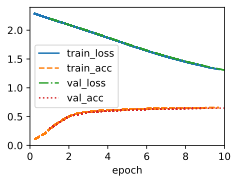

In [45]:
def stat_lr(lr):
    model = MLP(num_outputs=10, num_hiddens=256, lr=lr)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=True)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

lrs = [0.001, 0.01, 0.03, 0.1, 0.3, 1]
accs = []
accs.append(stat_lr(lrs[0]))

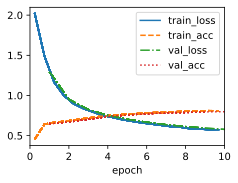

In [47]:
accs.append(stat_lr(lrs[1]))

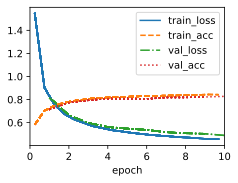

In [48]:
accs.append(stat_lr(lrs[2]))

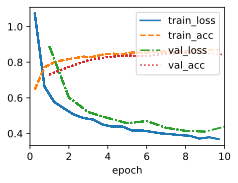

In [52]:
accs.append(stat_lr(lrs[3]))

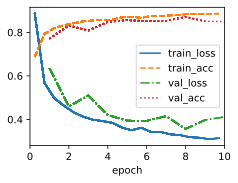

In [53]:
accs.append(stat_lr(lrs[4]))

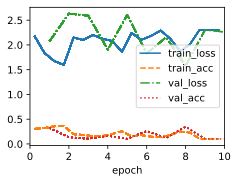

In [54]:
accs.append(stat_lr(lrs[5]))

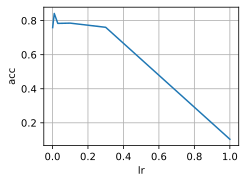

In [56]:
d2l.plot(lrs,accs[-len(lrs):],'lr','acc')

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
trainer.fit(model, data)

# 5. Let’s optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
- What is the best result you can get by optimizing over all of them?
- Why it is much more challenging to deal with multiple hyperparameters?
- Describe an efficient strategy for optimizing over multiple parameters jointly.

Optimizing over multiple hyperparameters jointly is a complex task, often referred to as hyperparameter tuning or hyperparameter optimization. Let's address your questions one by one:

**1. Best Result by Jointly Optimizing All Hyperparameters:**

The best result you can achieve by optimizing all hyperparameters jointly depends on the problem, dataset, and the interaction between hyperparameters. There's no universal answer as it's highly specific to the task. In some cases, a carefully optimized model might significantly outperform a default or randomly chosen hyperparameter configuration, leading to improved accuracy, convergence speed, and generalization. However, the absolute "best" result is challenging to determine due to the complexity of the optimization landscape.

**2. Challenges of Dealing with Multiple Hyperparameters:**

Dealing with multiple hyperparameters is more challenging due to the following reasons:

- **Curse of Dimensionality:** As you increase the number of hyperparameters, the search space grows exponentially, making it harder to explore efficiently.

- **Interaction Effects:** Hyperparameters can interact with each other in complex ways, affecting the overall behavior of the model. For example, the learning rate might impact the convergence behavior differently depending on the number of hidden layers or units.

- **Noisy or Uncertain Feedback:** The evaluation of a specific hyperparameter configuration might be noisy due to factors like random initialization, data variability, or runtime fluctuations.

- **Limited Resources:** Limited computational resources and time make exhaustive search impractical, requiring smarter search strategies.

**3. Efficient Strategy for Joint Optimization:**

Efficiently optimizing over multiple parameters requires a systematic approach. One commonly used strategy is Bayesian Optimization, which combines probability models and an acquisition function to guide the search towards promising regions of the hyperparameter space. Here's a general outline of the process:

1. **Define a Search Space:** Define ranges or distributions for each hyperparameter that you want to optimize.

2. **Select an Acquisition Function:** Choose an acquisition function (e.g., Expected Improvement, Upper Confidence Bound) that guides the search based on the uncertainty and predicted performance of different hyperparameter configurations.

3. **Build a Surrogate Model:** Create a probabilistic model that approximates the unknown relationship between hyperparameters and performance. Gaussian Process Regression is often used for this purpose.

4. **Iterative Search:** Start with an initial set of hyperparameters and evaluate the model's performance. Use the surrogate model and acquisition function to select the next hyperparameters to evaluate. Repeat this process iteratively, updating the surrogate model based on new evaluations.

5. **Convergence Criteria:** Stop the optimization process when a predefined number of iterations is reached or when the acquisition function suggests that exploration is unlikely to lead to further improvements.

Bayesian Optimization can help navigate the complex optimization landscape efficiently by focusing on promising regions and adapting the search based on the outcomes of past evaluations.

Remember that hyperparameter tuning is an iterative process, and the optimal configuration might depend on experimentation, domain knowledge, and the specifics of your problem. It's important to balance the exploration of hyperparameter space with the available computational resources and time

# 6. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?




In [67]:
class MulMLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        bef = num_inputs
        self.W = []
        self.b = []
        for num_hidden in num_hiddens:
            self.W.append(nn.Parameter(torch.randn(bef, num_hidden)*sigma))
            self.b.append(nn.Parameter(torch.zeros(num_hidden)))
            bef = num_hidden
        self.W.append(nn.Parameter(torch.randn(bef, num_outputs)*sigma))
        self.b.append(nn.Parameter(torch.zeros(num_outputs)))
        
        
    def forward(self, X):
        H = X.reshape(-1, self.num_inputs)
        for i in range(len(self.W)-1):
            H = relu(torch.matmul(H, self.W[i]) + self.b[i])
        return torch.matmul(H, self.W[-1]) + self.b[-1]
    
    def configure_optimizers(self):
        return d2l.SGD([*self.W, *self.b], self.lr)

def stat_time(model, data):
    t0 = time.time()
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    trainer.fit(model, data)
    return time.time() - t0


In [68]:
num_hiddens=[256,128,64,32,16]
ts = []
ts_strach = []
for i in tqdm(range(1,len(num_hiddens)+1)):
    model = MulMLP(num_outputs=10, num_hiddens=num_hiddens[:i], lr=0.1)
    model_scratch = MulMLPScratch(num_inputs=784, num_outputs=10, num_hiddens=num_hiddens[:i], lr=0.1)
    ts_strach.append(stat_time(model_scratch, data))
    ts.append(stat_time(model, data))

100%|██████████| 5/5 [23:18<00:00, 279.79s/it]


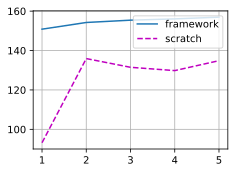

In [79]:
d2l.plot(list(range(1,len(num_hiddens)+1)),[ts,ts_strach],legend=['framework','scratch'])

# 7. Measure the speed of tensor–matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
- How does this change between GPUs and CPUs?
- Determine the memory bus width of your CPU and GPU.

# 8. Try out different activation functions. Which one works best?




In [105]:
class ActMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, act=act):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
        
def stat_act(act, data):
    model = ActMLP(num_outputs=10, num_hiddens=256, lr=0.1, act=act)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

In [106]:
acts = [nn.ReLU(),nn.Sigmoid(), nn.Tanh(),nn.LeakyReLU(negative_slope=0.01),nn.PReLU(num_parameters=1)]
accs = []
for act in tqdm(acts):
    accs.append(stat_act(act, data))

100%|██████████| 5/5 [12:36<00:00, 151.23s/it]


In [ ]:
d2l.plot(range(len(acts)),accs[-len(lrs):],'activation','acc')

# 9. Is there a difference between weight initializations of the network? Does it matter?


In [ ]:
import torch.nn.init as init


def init_xavier(module):
    if isinstance(module, nn.LazyLinear):
        init.xavier_uniform(module.weight)
        if module.bias is not None:
            init.constant_(module.bias, 0)
            
def init_uniform(module):
    if isinstance(module, nn.LazyLinear):
        init.uniform_(module.weight)
        if module.bias is not None:
            init.constant_(module.bias, 0)
            
def init_normal(module):
    if isinstance(module, nn.LazyLinear):
        init.normal_(module.weight)
        if module.bias is not None:
            init.constant_(module.bias, 0)
            
        
def stat_init(init_f, data):
    model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
    model.apply(init_f)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=True)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

In [ ]:
inits = [init_xavier,init_uniform,init_normal]
accs = []
for i in tqdm(inits):
    accs.append(stat_init(i, data))